# Assignment 4
 - a) We will be working with the **AFHQ (Animal Faces-HQ)** dataset: https://github.com/clovaai/stargan-v2
    - Approx 15.000 images of animal faces (cat, dog, tiger, ...)
    - Downsample the images to 64x64
 - b) Write **Convolutional** Variational Autoencoder (ConvVAE)
      - Use Conv. layers for encoder and Transposed-Conv. layers for decoder.
      - You are only allowed to use linear layers for estimating the mean and standard deviation. Everything else should be convolutional.
 - c) Investigate the importance of the KL-divergence weight. For this purpose, train multiple models (at least 4) using different weighting values and investigate how this value affects the generation performance.
 - d) Generate new images by sampling latent vectors, investigate latent space and visualize some interpolations.
 - e) Compare the models from b) and c)
     - Qualitative comparison. Which images look better?
     - Quantitative comparison between models using the Fréchet Inception Distance: https://arxiv.org/abs/1706.08500
     - Log generated images and losses into the Tensorboard/W&B
     
     
**Extra Point:**
 - Extend your ConvVAE for Image generation conditioned on a given class. The AFHQ dataset has 3 classes: 'cat', 'dog', and 'wildlife'
 - Train your Conditional-ConvVAE
 - Show that you can generate images conditioned on a label
 - Tutorial: https://ijdykeman.github.io/ml/2016/12/21/cvae.html

In [106]:
import os
import shutil
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from utils import *

from torch.utils.tensorboard import SummaryWriter

In [92]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
configs = {   
    "model_name" : "CVAE",
    "exp" : "3",  
    "latent_dim" : 256,
    "batch_size" : 64,
    "num_epochs" : 50,
    "lr" : 1e-3,
    "scheduler" : "ReduceLROnPlateau",
    "use_scheduler" : True,
    "lambda_kld" : 1e-3,
    }

In [4]:
dataset_root = './data/AFHQ/'

transform = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5]*3 , [0.5]*3)])

BS = configs["batch_size"]

train_dataset = datasets.ImageFolder(root= dataset_root+'train', transform= transform )
test_dataset = datasets.ImageFolder(root= dataset_root+'test', transform= transform )

# print(train_dataset.classes)  
print(train_dataset.class_to_idx)  

train_loader = DataLoader(dataset= train_dataset, 
                          batch_size= BS, 
                          shuffle= True, 
                          drop_last= True )

test_loader = DataLoader(dataset= test_dataset, 
                          batch_size= BS, 
                          shuffle= False, 
                          drop_last= True )

{'cat': 0, 'dog': 1, 'wild': 2}


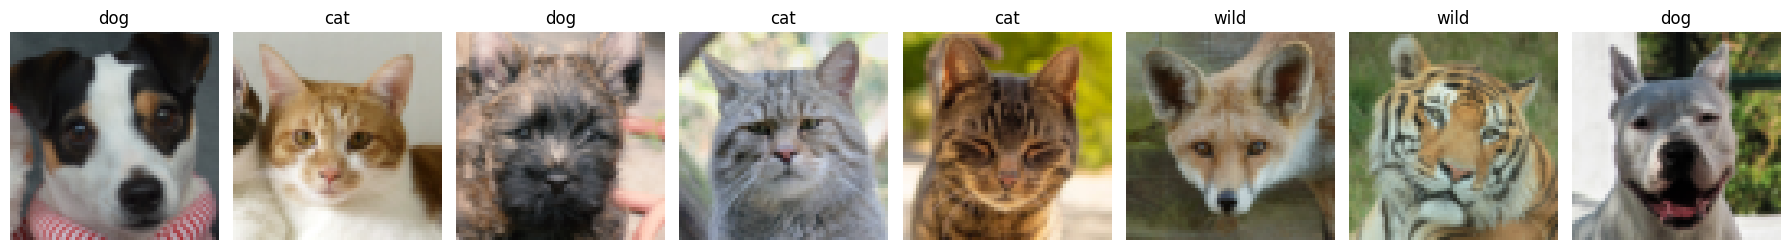

In [5]:
imgs, labels = next(iter(train_loader))
fig, ax = plt.subplots(1, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    img_np = imgs[i].permute(1, 2, 0).numpy()
    # Denormalize the image
    img_np = (img_np * 0.5 + 0.5).clip(0, 1)
    ax[i].imshow(img_np)
    ax[i].axis("off")
    ax[i].set_title(f"{train_dataset.classes[labels[i]]}")
plt.tight_layout()
plt.show()

In [6]:
imgs.shape

torch.Size([64, 3, 64, 64])

In [178]:
class CVAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=64):
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.in_channels = in_channels
        
        # Encoder
        self.encoder = self.make_encoder()
        
        # Fully connected layers for mu and sigma
        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_sigma = nn.Linear(2048, latent_dim)
        
        '''
        Also called projection layer, projects latent vector to  original dimensionality.
        maps the latent variable into a space compatible with the decoder input
        '''
        self.decoder_input = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder
        self.decoder = self.make_decoder()

    def make_encoder(self):
        
        return nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(self.in_channels, 16, kernel_size=4, stride=2, padding=1),  # (16, 32, 32)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Flatten()  # 128 * 4 * 4 = 2048
        )
        
    def make_decoder(self):
        return nn.Sequential(
            # Input: (128, 4, 4)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # (16, 32, 32)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(16, self.in_channels, kernel_size=4, stride=2, padding=1),  # (3, 64, 64)
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        """Reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        # Encode
        x_encoded = self.encoder(x)
        
        # Get mu and log_var
        mu = self.fc_mu(x_encoded)  # [batch_size, latent_dim]
        log_var = self.fc_sigma(x_encoded)  # [batch_size, latent_dim]
        
        # Reparameterization trick
        z = self.reparameterize(mu, log_var)  # [batch_size, latent_dim]
        
        # Project and reshape for decoder
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        x_hat = self.decoder(z)
        
        return x_hat, (z, mu, log_var) 
    

In [9]:

# class CVAE(nn.Module):
#     def __init__(self, in_channels=3, latent_dim=256):  # increased latent dim
#         super(CVAE, self).__init__()
        
#         self.latent_dim = latent_dim
        
#         # Encoder with more channels and residual connections
#         self.encoder = nn.Sequential(
#             # Input: (3, 64, 64)
#             nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # (32, 32, 32)
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.2),
            
#             nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (64, 16, 16)
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2),
            
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 8, 8)
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2),
            
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (256, 4, 4)
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
            
#             nn.Flatten()  # 256 * 4 * 4 = 4096
#         )
        
#         # Fully connected layers for mu and sigma
#         self.fc_mu = nn.Sequential(
#             nn.Linear(4096, 1024),
#             nn.LeakyReLU(0.2),
#             nn.Linear(1024, latent_dim)
#         )
        
#         self.fc_sigma = nn.Sequential(
#             nn.Linear(4096, 1024),
#             nn.LeakyReLU(0.2),
#             nn.Linear(1024, latent_dim)
#         )
        
#         # Enhanced decoder input projection
#         self.decoder_input = nn.Sequential(
#             nn.Linear(latent_dim, 1024),
#             nn.LeakyReLU(0.2),
#             nn.Linear(1024, 4096),
#             nn.LeakyReLU(0.2)
#         )
        
#         # Decoder with skip connections
#         self.decoder= nn.Sequential(
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 8, 8)
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2),

#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 16, 16)
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2),
        
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 32, 32)
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.2),

#             nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),  # (3, 64, 64)
#             nn.Sigmoid()  # Changed to Tanh for better gradient flow
#         )
        
#     def reparameterize(self, mu, log_var):
#         """Reparameterization trick with temperature annealing"""
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mu + eps * std
        
#     def forward(self, x):
#         # Encode
#         x_encoded = self.encoder(x)
        
#         # Get mu and log_var
#         mu = self.fc_mu(x_encoded)
#         log_var = self.fc_sigma(x_encoded)
        
#         # Reparameterization trick
#         z = self.reparameterize(mu, log_var)
        
#         # Project and reshape for decoder
#         z = self.decoder_input(z)
#         z = z.view(-1, 256, 4, 4)
#         x_hat = self.decoder(z)
         
#         return x_hat, (z, mu, log_var)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CVAE(latent_dim=configs["latent_dim"]).to(device)


In [11]:
# model

In [12]:
count_model_params(model.encoder)

691104

In [13]:
count_model_params(model.decoder)

690339

In [14]:
count_model_params(model.fc_mu) + count_model_params(model.fc_sigma) 

8915456

In [15]:
count_model_params(model)

14758467

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=configs["lr"], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7, factor=0.5, verbose=True)

/home/user/soltania1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
model_name = configs["model_name"]+configs["exp"]+f"_KLD{configs['lambda_kld']}"
savepath = f"imgs/{model_name}"
if os.path.exists(savepath):
    shutil.rmtree(savepath)
os.makedirs(savepath,exist_ok=True)

TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", model_name+f"_KLD{configs['lambda_kld']}")
if os.path.exists(TBOARD_LOGS):
    shutil.rmtree(TBOARD_LOGS)
os.makedirs(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [18]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=configs["lambda_kld"]):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [19]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=model, 
        model_name=model_name,
        optimizer=optimizer,
        scheduler=scheduler if configs["use_scheduler"] else None, 
        criterion=vae_loss_function,
        lambda_kld=configs["lambda_kld"],
        train_loader=train_loader, 
        valid_loader=test_loader, 
        num_epochs=configs["num_epochs"],
        save_frequency= 10, 
        savepath=savepath,
        writer=writer
    )

Epoch 1 Iter 224: loss 0.21442. : 100%|██████████| 224/224 [01:40<00:00,  2.23it/s]


    Train loss: 0.26323
    Valid loss: 0.5941
       Valid loss recons: 0.59403
       Valid loss KL-D:   0.06734


Epoch 3 Iter 224: loss 0.22185. : 100%|██████████| 224/224 [01:42<00:00,  2.18it/s]


    Train loss: 0.21622
    Valid loss: 0.21822
       Valid loss recons: 0.20841
       Valid loss KL-D:   9.80407


Epoch 5 Iter 224: loss 0.20164. : 100%|██████████| 224/224 [01:43<00:00,  2.15it/s]


    Train loss: 0.21037
    Valid loss: 0.21273
       Valid loss recons: 0.20156
       Valid loss KL-D:   11.17414


Epoch 7 Iter 224: loss 0.20101. : 100%|██████████| 224/224 [01:41<00:00,  2.21it/s]


    Train loss: 0.20702
    Valid loss: 0.20963
       Valid loss recons: 0.2
       Valid loss KL-D:   9.62826


Epoch 9 Iter 224: loss 0.22964. : 100%|██████████| 224/224 [01:42<00:00,  2.19it/s]


    Train loss: 0.20564
    Valid loss: 0.20693
       Valid loss recons: 0.19662
       Valid loss KL-D:   10.31014


Epoch 10 Iter 224: loss 0.20260. : 100%|██████████| 224/224 [01:43<00:00,  2.16it/s]

    Train loss: 0.20525
    Valid loss: 0.20648
       Valid loss recons: 0.19608
       Valid loss KL-D:   10.40073
Training completed


### Saving model and training configs

In [ ]:
configs_dir = f"./configs/{model_name}/"
if not os.path.exists(configs_dir):
    os.makedirs(configs_dir,exist_ok=True)
configs_path = configs_dir + "/config.yaml"

def save_config(config, path):
    with open(path, 'w') as f:
        yaml.dump(config, f)

epoch = configs["num_epochs"]
lambda_kld = configs["lambda_kld"]

save_model(model, model_name, optimizer, epoch = epoch,lambda_kld = lambda_kld, stats = configs )
save_config(configs, configs_path)


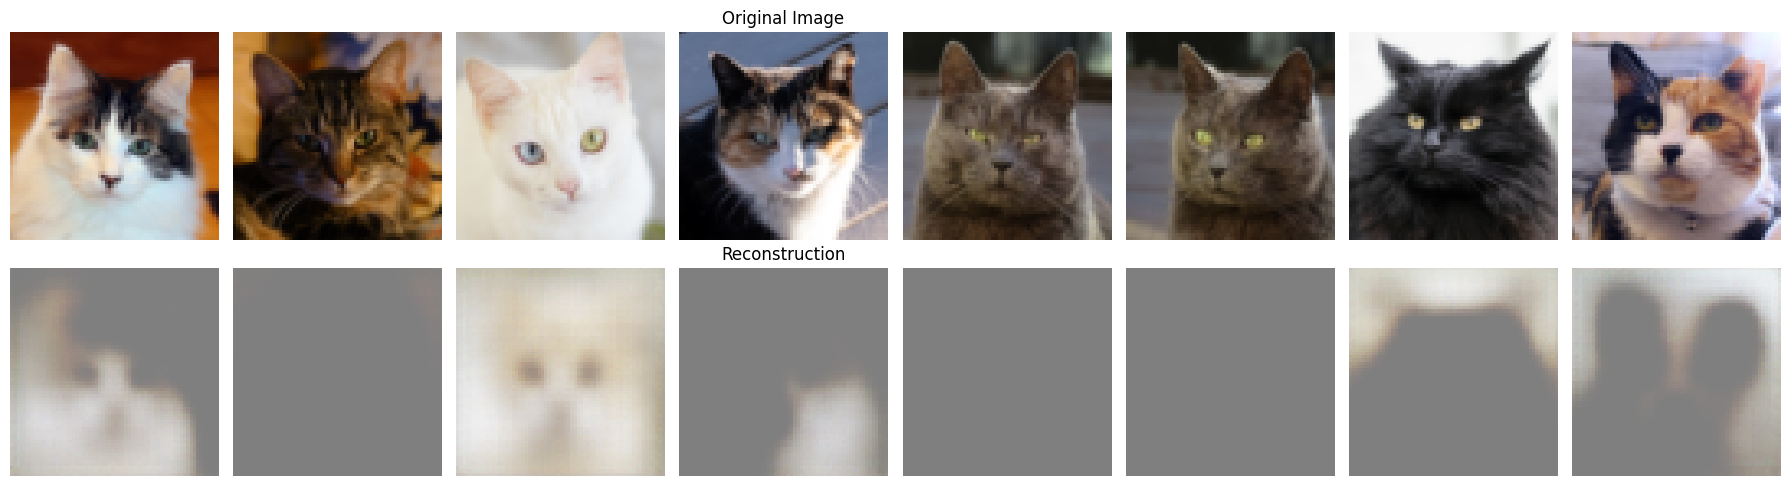

In [29]:
img_vs_recons(model, test_loader, device)

In [56]:
def compute_encoder_output_size(batch_size, input_shape):
    """
    Compute the un/flattened output size of the encoder given an input shape.
    """
    with torch.no_grad():

        enc_input = torch.zeros(batch_size, *input_shape).to(device)  # (BS, 3, 64, 64)
        
        # Get encoder output
        output = model.encoder(enc_input)
        
        enc_out_shape = output.view(BS,-1,4,4).shape[1:]
        # Get flattened size
        flattened_size = output.view(1, -1).shape[1]
        
    return enc_out_shape, flattened_size


In [57]:
compute_encoder_output_size(BS, (3, 64, 64))

(torch.Size([256, 4, 4]), 262144)

## Inference 

Sampling random tensors from a normal districution and investigating if the model has learnt to map any random vercor with normal distribution to a meaningful resresentation

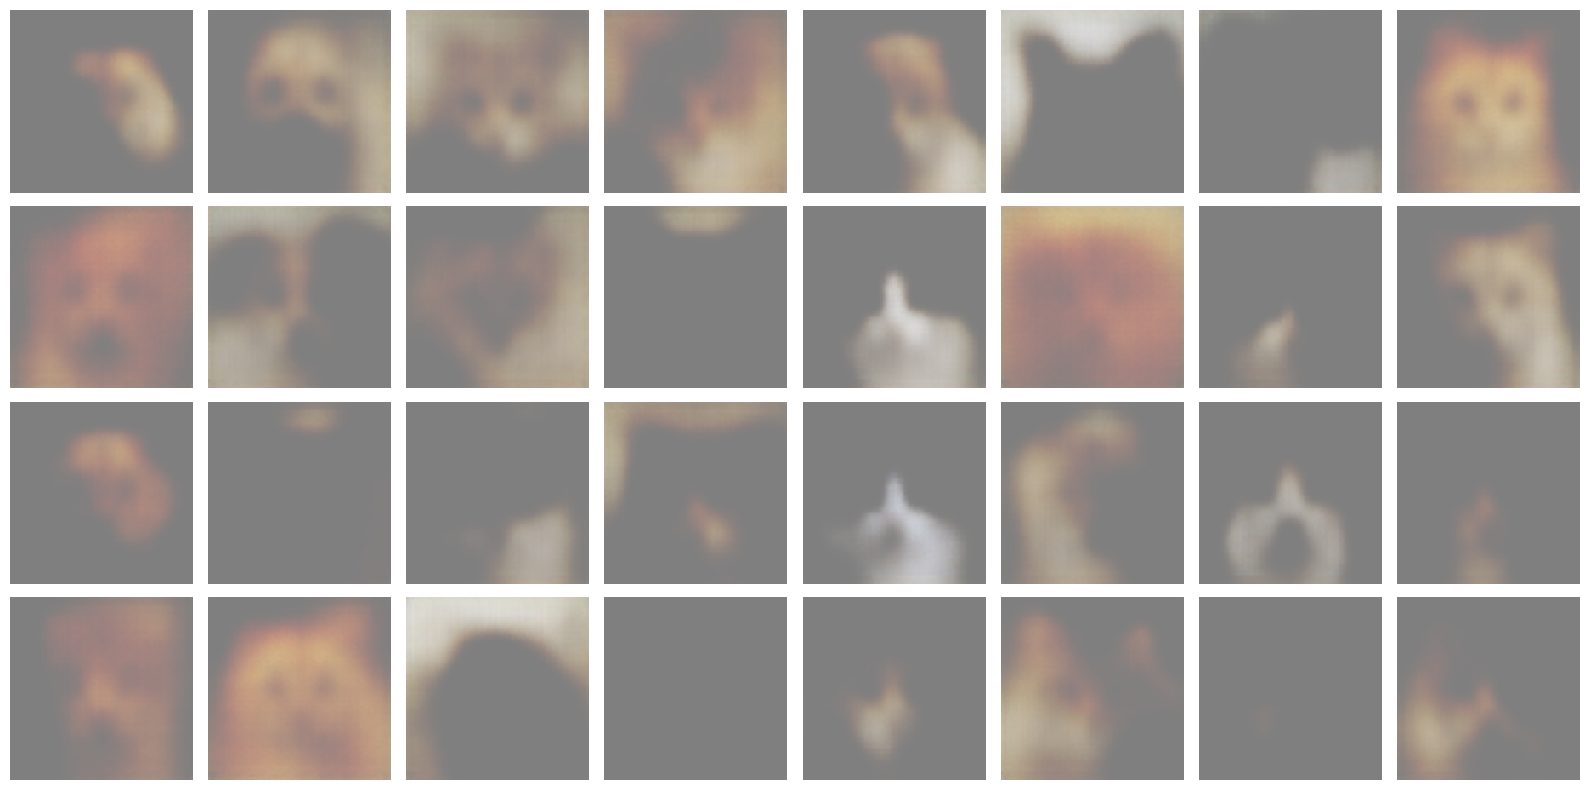

In [170]:
if not os.path.exists(f"imgs/inference/{model_name}"):
    os.makedirs(f"imgs/inference/{model_name}")

latent_dim = configs["latent_dim"]

enc_output_shape, _ = compute_encoder_output_size(BS, (3, 64, 64))
# print(enc_output_shape)
with torch.no_grad():
    for i in range(5):
        z = torch.randn(BS, latent_dim).to(device)

        z = model.decoder_input(z)
        z = z.view(-1, *enc_output_shape)

        recons = model.decoder(z)
        recons = recons.view(BS, 3, 64, 64)
        save_image(recons, f"imgs/inference/{model_name}/inference_{i}.png")

def plot_recons(recons):
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        recon_img = denormalize_images(recons[i].cpu())
        # recon_img = recons[i].cpu()
        recon_img = recon_img.permute(1, 2, 0)
        plt.imshow(recon_img)  
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
plot_recons(recons)


### Latent space  visualization

In [69]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = model(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

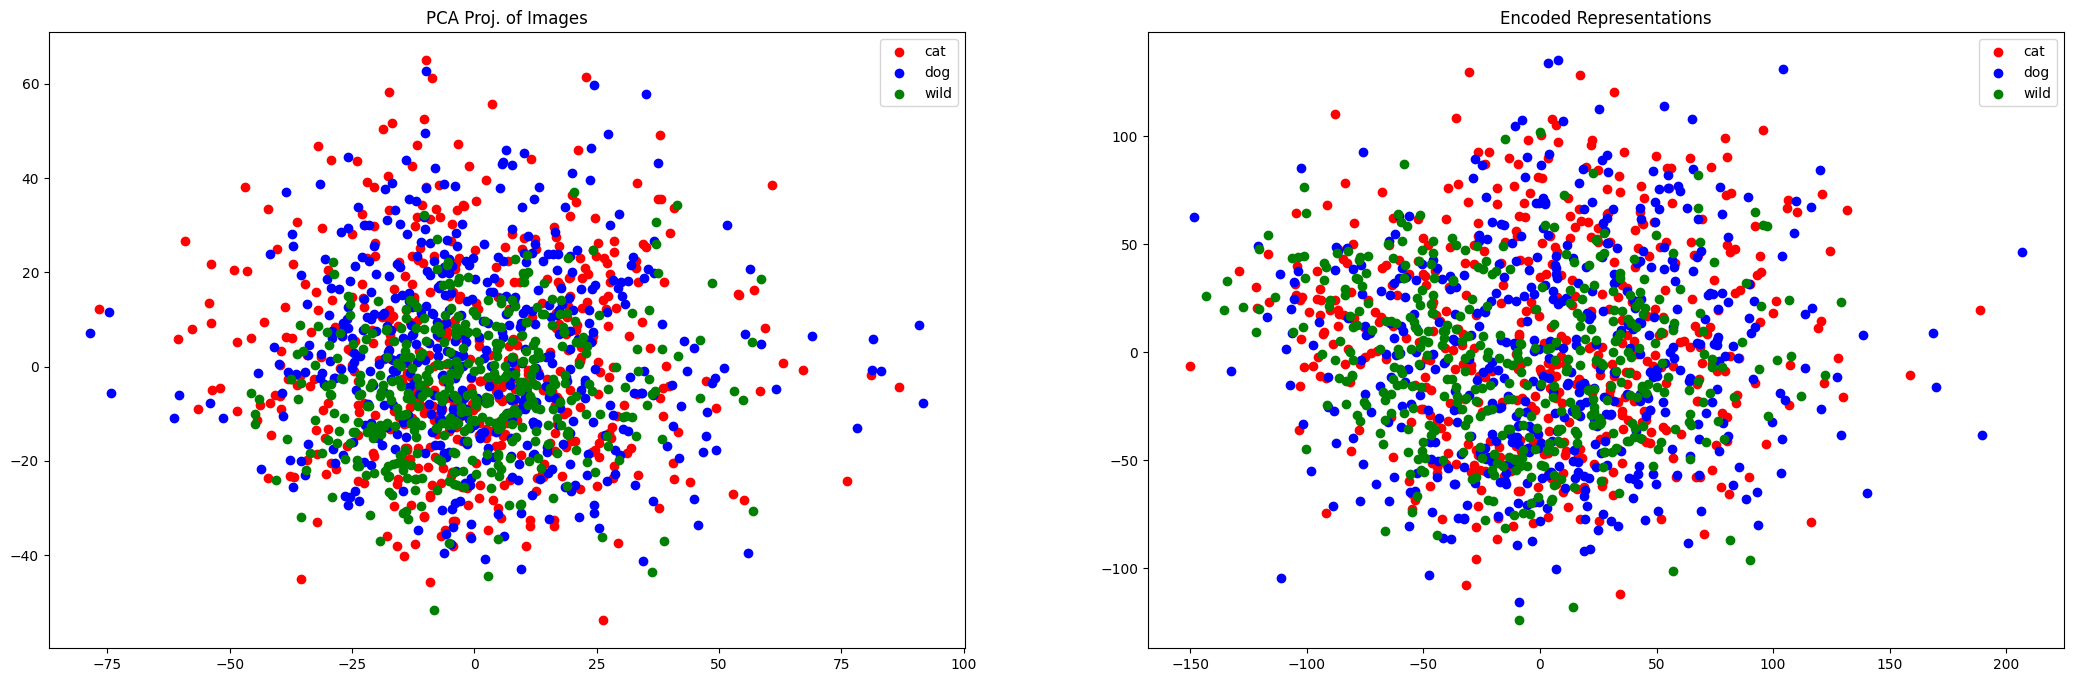

In [83]:

latents_reshaped = latents.reshape(latents.shape[0], -1)

pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_latents = PCA(n_components=2).fit_transform(latents_reshaped)

N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()

## Interpolation

1. Understanding the Latent Space:
The latent space is a compressed representation of images
By sampling different points, we can see how the decoder maps these points to images

2. Helps us understand what the model has learned and to verify if the model has learned meaningful features

3. Visualization of the Model's Behavior:
Shows how the model generalizes to new inputs

4. Reveals the structure of the learned latent space

5. Interpolation and Generation:
By `sampling normal distributions with linspace mean and std values`, we can move through the latent space
and realize how the model generate new images. 

In [174]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space given the xrange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    # Project points to decoder input dimension (same as in forward pass)
    SIZE = 64  # Image size
    grid = np.empty((N*SIZE, N*SIZE, 3))  # 3 channels for RGB
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            # mean
            mu = torch.zeros(model.latent_dim, device=device)
            mu[0] = x
            mu[1] = y
            
            # standard deviation
            sigma = 1 
            z = torch.normal(mean=mu, std=sigma)
            
            # Passing through the decoder 
            z = model.decoder_input(z)
            z = z.view(-1, 256, 4, 4)  # Reshape to match decoder input
            
            # Getting recons
            x_hat = model.decoder(z)
            
            # To visualize
            x_hat = x_hat.squeeze(0).cpu()  # Remove batch dimension
            x_hat = x_hat.permute(1, 2, 0)  # (C,H,W) to (H,W,C)
            recon_img = x_hat.numpy()
            
            # Prepare the image for visualization
            recon_img = denormalize_images(recons[i].cpu())
            recon_img = recon_img.permute(1, 2, 0)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = recon_img
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange])
    plt.axis("off")
    plt.show()

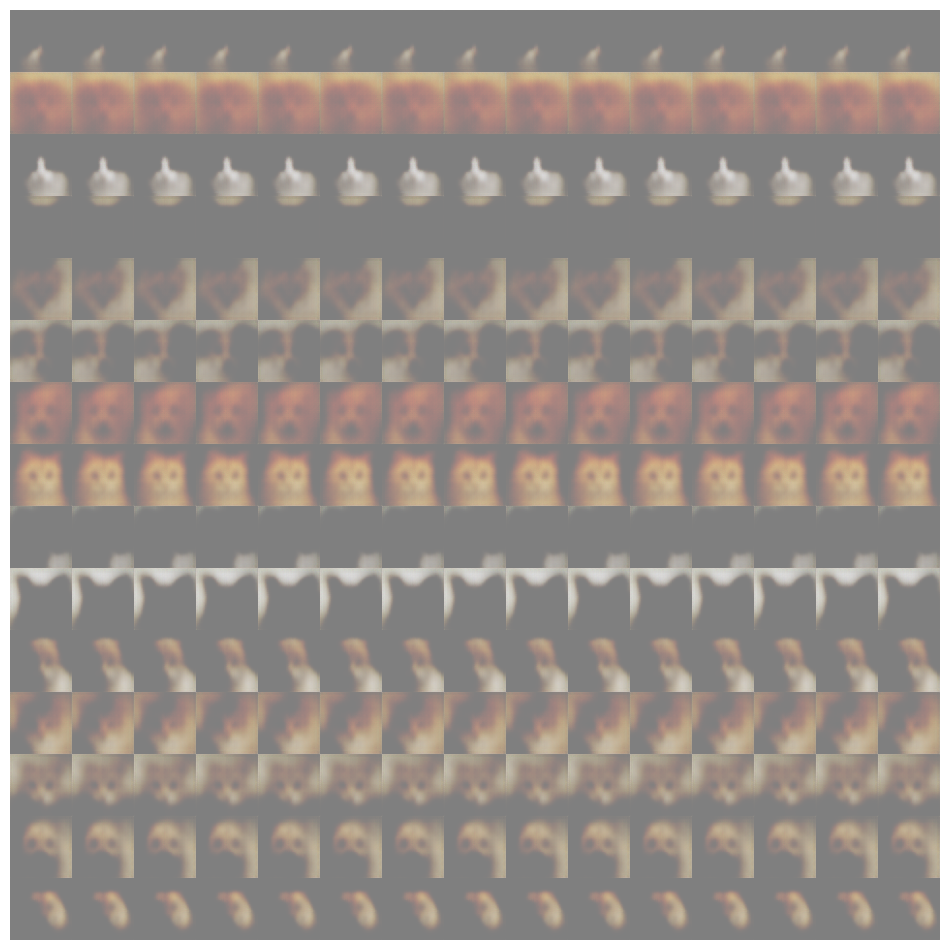

In [177]:
plot_reconstructed(model, xrange=(-50, 50), yrange=(-50, 50), N=15)

### Investigating the importance of the KL-divergence

In Variational Autoencoders (VAEs), the loss is:
**Total Loss = Reconstruction Loss + λ * KLD**

Reconstruction Loss (e.g. MSE): Measures how well the VAE reconstructs the input.

KLD: Encourages the latent space distribution to be close to a standard normal (regularization).

There is a the trade-off between:

1. Accurate reconstructions (low MSE)
2. Structured latent space (low KLD)

If:

lambda_kld is too low → poor latent structure (overfit to data, bad generative quality)

lambda_kld is too high → poor reconstructions (model ignores input to match prior)

lambda_kld_values = [0.0, 1e-4, 1e-3, 1e-2]

| λ (KLD weight) | Effect                                                      |
| -------------- | ----------------------------------------------------------- |
| `0.0`          | Pure autoencoder (no latent regularization)                 |
| `1e-4`         | Very weak KLD → good reconstructions, weak latent structure |
| `1e-3`         | Balanced trade-off                                          |
| `1e-2`         | Strong KLD → worse recons, better sampling and latent space |

